# 1) Importing Libraries

In [1]:
# Default libraries, packages for data management, visualization and Computer vision libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Sklearn package -> function
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Tensorflow packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPool2D, 
                                     BatchNormalization, Flatten, GlobalAveragePooling2D, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB7, MobileNetV2, VGG19, DenseNet121

# 2) Helper Functions & Hyperparameters

- **This section to define all Helper functions through the notebook and any hyperparameters used later for training the models**

In [29]:
def directory_to_df(path : str):
    """
    This function to retrieve all images from targeted folder in a file, the
    folder must be divided hirarchally in which each class contains its images individually.
    ________________________________________________________________________________________________
    Arguments-
    
    path: String -> the main folder directory that contains train/test folders
    
    ________________________________________________________________________________________________
    Return-
    
    DataFrame: contains the images path and label corresponding to every image
    """
    df = []
    chars = 'abcdefghijklmnopqrstuvwxyz'    # to include lowercase letters only
    for cls in os.listdir(path):
        cls_path = os.path.join(path,cls)
        cls_name = cls.split('_')[0]
        if not cls_name in chars:
            continue
        for img_path in os.listdir(cls_path):
            direct = os.path.join(cls_path,img_path)
            df.append([direct,cls_name])
    
    df = pd.DataFrame(df, columns=['image','label'])
    print("The number of samples found:",len(df))
    return df.copy()

def read_image(path):
    """
    Read an image from specified directory
    _____________________________________________________________
    Arguments:
    
    path: String -> a directory of the image
    _____________________________________________________________
    Return:
    
    image: numpy.array of the image
    """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def show_image(img, label=None) -> None:
    """
    This function to display any image
    _________________________________________________________
    Arguements:
    
    img: numpy.array of N-D
    
    label: String -> the title/label added with the image, Default= None
    _________________________________________________________
    Return:
    
    plt.imshow()
    """
    plt.imshow(img, cmap='gray')
    plt.axis(False)
    plt.title(label)
    plt.show()
    
def clbck(model_name):
    # The function is defined to make the callbacks for training the models
    ERLY = EarlyStopping(patience=10, min_delta=0.01, start_from_epoch=10, verbose=1)
    RD = ReduceLROnPlateau(patience=5, min_delta=0.01, factor=0.5)
    CHK = ModelCheckpoint(f'{model_name}_model.keras',verbose=1, save_best_only=True)
    return [ERLY,RD,CHK]

In [3]:
# Pre-defined hyperparameters
IMG_SHAPE = (32,32)
IMG_SIZE = (32,32,3)
BATCH_SIZE = 32
opt = Adam(learning_rate=0.00001, epsilon=1e-6)
loss = 'categorical_crossentropy'
EPOCHS = 10

In [4]:
print(tf.__version__)

2.18.0


In [5]:
from tensorflow.python.framework import ops
ops.get_default_graph()


In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11747330776655770565
xla_global_id: -1
]


In [7]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')  # Set first GPU as visible
    print(f"Using GPU: {physical_devices[0]}")
else:
    print("No GPUs found")

No GPUs found


In [8]:
from tensorflow.python.framework import ops
ops.get_default_graph()


# 3) Reading & preparing the dataset

In [9]:
# Reading the dataset in dataframe 
main_path = 'dataset'
df = directory_to_df(main_path)                   # convert the dataset into df of two columns
df.head()

The number of samples found: 85199


,image,label
0,dataset\a_L\A_L_1.png,a
1,dataset\a_L\A_L_10.png,a
2,dataset\a_L\A_L_100.png,a
3,dataset\a_L\A_L_1000.png,a
4,dataset\a_L\A_L_1001.png,a


In [10]:
df['label'].value_counts()

label
e    3284
r    3284
n    3281
m    3281
a    3281
q    3279
u    3278
i    3277
d    3277
k    3276
y    3276
x    3276
t    3276
l    3276
s    3276
h    3275
f    3275
g    3275
o    3275
w    3275
z    3275
p    3275
j    3274
c    3274
b    3274
v    3274
Name: count, dtype: int64

## 3.1) Splitting the dataframe
- The dataframe is splitted to get 70% of the dataset for `training` , and 30% for `testing`
- The training set is splitted into `training` and `validation` to enhance the model training

In [11]:
# Splitting for training & testing (70,30 respectively)
X, y = df['image'], df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
testing_df = pd.concat((X_test,y_test), axis=1)

In [12]:
# Splitting for training & validation (75,25 respectively) -> the training set size = 52.5%
X, y = training_df['image'], training_df['label']
X_train, X_valid, y_train, y_valid = train_test_split(X,y , test_size=0.25, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
validation_df = pd.concat((X_valid,y_valid), axis=1)

## 3.2) Creating generators
- The `ImageDataGenerators` is used for data augmentation, the augmentation is required since the `OCR` can work with different brightness which is not included in the dataset.
- Also, it enhance the RAM usage.

In [13]:
# Creating generators
gen = ImageDataGenerator(dtype=np.int32, brightness_range=[0.0,1.0], fill_mode='nearest')
gen2 = ImageDataGenerator(dtype=np.int32, fill_mode='nearest')
train_gen = gen.flow_from_dataframe(training_df, x_col='image',y_col='label', batch_size=BATCH_SIZE, 
                                   target_size=IMG_SHAPE)
valid_gen = gen2.flow_from_dataframe(validation_df, x_col='image', y_col='label', batch_size=BATCH_SIZE, 
                                        target_size=IMG_SHAPE, shuffle=False)
test_gen = gen2.flow_from_dataframe(testing_df, x_col='image', y_col='label', batch_size=BATCH_SIZE, 
                                       target_size=IMG_SHAPE, shuffle=False)

Found 44729 validated image filenames belonging to 26 classes.
Found 14910 validated image filenames belonging to 26 classes.
Found 25560 validated image filenames belonging to 26 classes.


In [14]:
# Making a mapping of the classes and the inverse for later processings
mapping = train_gen.class_indices
mapping_inverse = dict(map(lambda x: tuple(reversed(x)), mapping.items()))

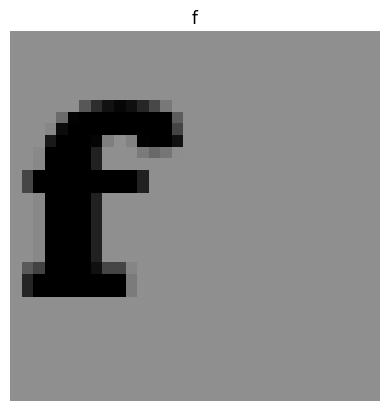

The shape of the image: (32, 32, 3)


In [15]:
# Reading a sample from the dataset
BATCH_NUM = 10
IMG_NUM = 2      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

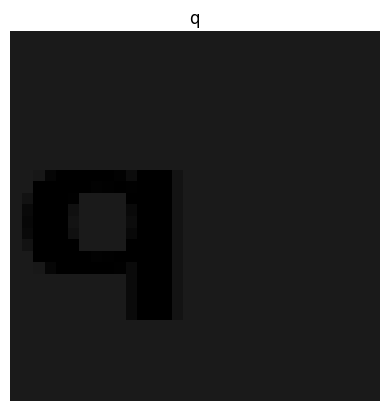

The shape of the image: (32, 32, 3)


In [16]:
# Reading another sample from the dataset
BATCH_NUM = 65
IMG_NUM = 30      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

# 4) Modeling
*Our target is to build a **`custom CNN model`** to train on our targeted images for the `OCR` application. in advance, we also will use 4 Pre-trained models as part of `Transfer Learning` and to enhance the performance of the application.*

***Our targeted pretrained models are the following:***

*- EfficientNetB7*

*- MobileNetV2*

*- VGG19*

*- DenseNet121*

***The fine-tuning strategy:*** *using a small value of `LR` of the optimizer `Adam` will make an efficient use of the pre-trained models on our dataset without **FREEZING** the input layers in which better performance is required in our case*

## 4.1) Custom CNN

In [17]:
# Custom CNN
CNN_model = Sequential()
CNN_model.add(Input(shape=IMG_SIZE, batch_size=BATCH_SIZE, name='Input'))
CNN_model.add(Conv2D(3, (3,3), strides=1, activation='relu', padding='same'))
CNN_model.add(Conv2D(128, (3,3), activation='relu'))
CNN_model.add(MaxPool2D((3,3)))
CNN_model.add(Conv2D(256, (3,3), activation='relu'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(256, (3,3), strides=2, activation='relu', padding='same'))
CNN_model.add(MaxPool2D((2,2)))
CNN_model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(1024, (2,2), activation='relu', padding='same'))
CNN_model.add(MaxPool2D(2,2))
CNN_model.add(Flatten())
CNN_model.add(Dense(1024, activation='selu'))
CNN_model.add(Dense(len(mapping), activation='softmax'))

In [18]:
CNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (32, 32, 32, 3)        │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 30, 30, 128)      │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 10, 10, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 8, 8, 256)        │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 8, 8, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 4, 4, 256)        │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 2, 2, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 2, 2, 512)        │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 2, 2, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 2, 2, 1024)       │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 1, 1, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 1024)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 1024)             │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 26)               │        26,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,243,502 (20.00 MB)

 Trainable params: 5,243,502 (20.00 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Default parameters of adam will be used for the custom CNN
CNN_model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])

In [ ]:
# different num. of epochs will be given for better convergence for the Custom CNN
history = CNN_model.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=clbck("CustomCnn"))

c:\Users\LENOVO\Seimbang.in\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.5119 - loss: 1.8173
Epoch 1: val_loss improved from inf to 0.49231, saving model to CustomCnn_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 547s 390ms/step - accuracy: 0.5120 - loss: 1.8168 - val_accuracy: 0.8818 - val_loss: 0.4923 - learning_rate: 0.0010
Epoch 2/20
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8793 - loss: 0.4320
Epoch 2: val_loss did not improve from 0.49231
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 318s 228ms/step - accuracy: 0.8793 - loss: 0.4320 - val_accuracy: 0.8814 - val_loss: 0.5747 - learning_rate: 0.0010
Epoch 3/20
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8952 - loss: 0.3821
Epoch 3: val_loss improved from 0.49231 to 0.30354, saving model to CustomCnn_model.keras
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 535s 383ms/step - accuracy: 0.8952 - loss: 0.3821 - val_accuracy: 0.9203 - val_loss: 0.3035 - learning_rate: 0.0010
Epoch 4/20
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("Custom CNN Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the Custom CNN for the testing set for the evaluation
prediction = CNN_model.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

In [ ]:
print('\t\tThe Custom CNN Evaluation Performance')
print(classification_report(y_test, pred))

## 4.2) EfficientNetB7

In [ ]:
# EfficientNetB7 input layers will not be FREEZED
train_layers = EfficientNetB7(include_top=False, input_shape=IMG_SIZE)
EffNetB7 = Sequential()
EffNetB7.add(train_layers)
EffNetB7.add(Flatten())
EffNetB7.add(Dense(1024, activation='selu'))
EffNetB7.add(Dropout(0.2))
EffNetB7.add(Dense(512, activation='selu'))
EffNetB7.add(Dense(len(mapping), activation='softmax'))

In [ ]:
EffNetB7.summary()

In [ ]:
# The pre-defined optimizer will be used with too small learning rate
EffNetB7.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
history2 = EffNetB7.fit(train_gen, epochs=EPOCHS, validation_data=valid_gen, callbacks=clbck("EfficientNetB7"))

In [ ]:
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("EfficientNetB7 Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the EfficientNetB7 for the testing set for the evaluation
prediction = EffNetB7.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

In [ ]:
print('\t     The EfficientNetB7 Evaluation Performance')
print(classification_report(y_test, pred))

## 4.3) MobileNetV2

In [ ]:
# MobileNetV2 input layers will not be FREEZED
train_layers = MobileNetV2(include_top=False, input_shape=IMG_SIZE)
MobNetV2 = Sequential()
MobNetV2.add(train_layers)
MobNetV2.add(Flatten())
MobNetV2.add(Dense(1024, activation='selu'))
MobNetV2.add(Dropout(0.2))
MobNetV2.add(Dense(512, activation='selu'))
MobNetV2.add(Dense(len(mapping), activation='softmax'))

In [ ]:
MobNetV2.summary()

In [ ]:
MobNetV2.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
history3 = MobNetV2.fit(train_gen, epochs=EPOCHS, validation_data=valid_gen, callbacks=clbck('MobileNetV2'))

In [ ]:
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("MobileNetV2 Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the MobileNetV2 for the testing set for the evaluation
prediction = MobNetV2.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

In [ ]:
print('\t     The MobileNetV2 Evaluation Performance')
print(classification_report(y_test, pred))

## 4.4) VGG19

In [ ]:
# VGG19 input layers will not be FREEZED
train_layers = VGG19(include_top=False, input_shape=IMG_SIZE)
VG = Sequential()
VG.add(train_layers)
VG.add(Flatten())
VG.add(Dense(1024, activation='selu'))
VG.add(Dense(512, activation='selu'))
VG.add(Dense(len(mapping), activation='softmax'))

In [ ]:
VG.summary()

In [ ]:
VG.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
history4 = VG.fit(train_gen, validation_data=valid_gen, epochs=EPOCHS, callbacks=clbck('VGG19'))

In [ ]:
plt.plot(history4.history['loss'], label='Training loss')
plt.plot(history4.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("VGG19 Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the VGG19 for the testing set for the evaluation
prediction = VG.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

In [ ]:
print('\t\tThe VGG19 Evaluation Performance')
print(classification_report(y_test, pred))

## 4.5) DenseNet121 

In [ ]:
# DenseNset121 input layers will not be FREEZED
train_layers = DenseNet121(include_top=False, input_shape=IMG_SIZE)
Den = Sequential()
Den.add(train_layers)
Den.add(Flatten())
Den.add(Dense(1024, activation='selu'))
Den.add(Dense(512, activation='selu'))
Den.add(Dense(len(mapping), activation='softmax'))

In [ ]:
Den.summary()

In [ ]:
Den.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
history5 = Den.fit(train_gen, validation_data=valid_gen, epochs=10, callbacks=clbck("DenseNet121"))

In [ ]:
plt.plot(history5.history['loss'], label='Training loss')
plt.plot(history5.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("DenseNet121 Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the DenseNet121 for the testing set for the evaluation
prediction = Den.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

In [ ]:
print('\t\tThe DenseNet121 Evaluation Performance')
print(classification_report(y_test, pred))

# 5) Evaluation & Comparison

In [ ]:
vals = {'accuracy':[0.95,0.93,0.71,0.96,0.95], 'precision':[0.96,0.94,0.72,0.96,0.95],
       'recall':[0.95,0.93,0.71,0.96,0.95], 'F1-Score':[0.95,0.93,0.71,0.96,0.95]}
results = pd.DataFrame(vals, index=['Custom CNN','EfficientNetB7','MobileNetV7','VGG19',
                                   'DenseNet121'])

print("\t\tThe Evaluation results of CNN/Pre-trained models")
print(results)

In [ ]:
sns.barplot(data=results, x=results.index, y='accuracy')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models Accuracy")
plt.show()

In [ ]:
sns.barplot(data=results, x=results.index, y='precision')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models Precision")
plt.show()

In [ ]:
sns.barplot(data=results, x=results.index, y='recall')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models Recall")
plt.show()

In [ ]:
sns.barplot(data=results, x=results.index, y='F1-Score')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models F1-Score")
plt.show()

# 6) Post-Processing
#### **THIS SECTION IS ABOUT `Computer Vision` TECHNIQUES**

*the image will be taken from the user/externally to be processed and input into our model. some **LOW LEVEL COMPUTER VISION TECHNIQUES** are used in order to enhance the input image, wheter it is text or handwritten, these techniques are the following:*

- **Binarization:** The binarization function applies Otsu's binarization to the grayscale image, producing a binary image.

- **Dilate:** The dilate function performs morphological dilation on the binary image. The degree of dilation is adjusted based on whether processing `words` or `characters`.

- **Find Rectangles:** The find_rect function identifies bounding rectangles in the binary image, sorting them based on their **x-coordinate (From Left-to-Right)**.

- **Extract Characters:** The extract function uses the aforementioned techniques to extract characters from the image. It identifies words **FIRST**, then extracts characters from each word, and with the use of the pre-trained deep learning model to recognize each character.

In [ ]:
# Computer Vision - Low level techniques
def load_model():
    model_path = 'DenseNet121_model.keras'
    model = tf.keras.saving.load_model(model_path)
    return model

def convert_2_gray(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray_image

def binarization(image):
    img, thresh = cv2.threshold(image, 0,255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
    return img, thresh

def dilate(image, words= False):
    img = image.copy()
    m = 3
    n = m - 2                   # n less than m for Vertical structuring element to dilate chars
    itrs = 4
    if words:
        m = 6
        n = m
        itrs = 3
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (n, m))
    dilation = cv2.dilate(img, rect_kernel, iterations = itrs)
    return dilation

def find_rect(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    rects = []
    
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)  # Extract the bounding rectangle coordinates of each countour
        rects.append([x,y,w,h])
        
    sorted_rects = list(sorted(rects, key=lambda x: x[0])) # Sorting the rects from Left-to-Right
    return sorted_rects

def extract(image):
    model = load_model()
    chars = []              # a list to store recognized characters
    
    image_cpy = image.copy()
    _, bin_img = binarization(convert_2_gray(image_cpy))
    full_dil_img = dilate(bin_img,words=True)
    words = find_rect(full_dil_img)                       # Recognized words within the image 
    del _, bin_img, full_dil_img                          # for better memory usage
    
    for word in words:
        x,y,w,h = word                                    # coordinates of the word
        img = image_cpy[y:y+h, x:x+w]
        
        _, bin_img = binarization(convert_2_gray(img))
        dil_img = dilate(bin_img)
        char_parts = find_rect(dil_img)                     # Recognized chars withtin the word
        cv2.rectangle(image, (x,y),(x+w,y+h), (0,255,0), 3) # draw a green rectangle around the word
        
        del _, bin_img, dil_img
        
        for char in char_parts:    
            x,y,w,h = char
            ch = img[y:y+h, x:x+w]
            
            empty_img = np.full((32,32,1),255, dtype=np.uint8) # a white image used for resize with filling
            x,y = 3,3                                          # starting indecies
            resized = cv2.resize(ch, (16,22), interpolation=cv2.INTER_CUBIC)
            gray = convert_2_gray(resized)
            empty_img[y:y+22, x:x+16,0] = gray.copy()          # integrate the recognized char into the white image
            gray = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
            gray = gray.astype(np.int32)
            
            predicted = mapping_inverse[np.argmax(model.predict(np.array([gray]), verbose=-1))]
            chars.append(predicted)                            # append the character into the list
            
            del ch, resized, gray, empty_img
        chars.append(' ')  # at the end of each iteration (end of word) append a space
        
    del model
    show_image(image)
    return ''.join(chars[:-1])

## 6.1) Testing

In [ ]:
# Testing 1
img = read_image('')
text = extract(img)
print('-->',text)

In [ ]:
# Testing 2
img2 = read_image('')
text = extract(img2)
print('-->',text)

In [ ]:
# Testing 3
img3 = read_image('')
text = extract(img3)
print('-->',text)

In [ ]:
# Testing 4
img4 = read_image('')
text = extract(img4)
print('-->',text)